# Synthetic Data experiments

In this notebook, the experiments to produce the results and Figures from Section 2.4 of the paper are presented. The results are split up into sections, as indicated below.

## Index
1. [A First Impression of the Differences](#ref1)
2. [Extensive Synthetic Experiments](#ref2)

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# Local imports
%run ../utils/metricutils.py

%matplotlib inline

## Generating Synthetic Data

For all the experiments listed below, we create synthetic clustering data to evaluate the differences between ELM and BCUBED. For this we use a binary representation of clusters, such that a 1 indicates a new cluster, and a 0 indicates membership to an existing cluster. For example, the binary representation `[1, 0, 0, 1, 1]` represents three clusters, {1, 2, 3}, {4}, {5}. For the conversion between the binary representation and other representations, please see the `metricutils.py` file, which contains several convenience functions for this purpose.

In [2]:
from itertools import product
def get_partitions(list_length: int):
    """
    :list_length: int specifying the number of elements in
    the total set over which possible clusterings should be
    generated. As described above, we work with the binary
    representations of clusters.
    """

    output_partitions = []
    # This generates all possible permutations of zeros and ones for a set of elements
    # length `list_length-1`. We do this, as, by convention in our representation, the first
    # element is always a zero in our case to make the computation more efficient,
    # and thus we don't have to get the permutations for this first element.
    binary_permutations = np.array([i for i in product(range(2), repeat=list_length-1)])
    
    # We do a hstack with zeros to make the first column zeros, so that we can
    # later use the nonzero indices in the array to make partitions
    possible_binary_partitions = np.hstack([np.zeros(shape=(binary_permutations.shape[0], 1)),
                                     binary_permutations])
    
    element_numbers = np.arange(1, list_length+1)
    
    for partition in possible_binary_partitions:
        # Get the indices of the 'breaks' in the clusters
        partition_indices = np.nonzero(partition)[0]
        # Use array_split to split the list of element numbers 
        # into clusters of consecutive element numbers
        raw_splits = np.array_split(element_numbers, partition_indices)
        # Put all the partitions in an output list, and check if they actually
        # contain anything
        splits = [list(item) for item in raw_splits if item.any()]
        output_partitions.append(splits)

    return output_partitions


In [3]:
# Quick conversion funtion to go from splits to a list with the lengths
# of the clusters within it.
def from_split_to_lengths(split):
    return [len(p) for p in split]

Let's do a small test with this function, where we get all the possible partitions for a set of 12 elements, and print the history of cluster sizes.

2048
CPU times: user 593 ms, sys: 21.3 ms, total: 614 ms
Wall time: 189 ms


<AxesSubplot: >

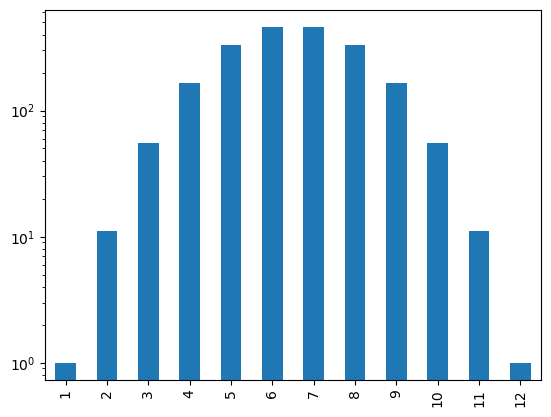

In [4]:
%%time
splits = defaultdict(int)
for split in get_partitions(12):
    splits[len(split)]+=1
    
S = pd.Series(splits)
#sns.histplot(S, kde=True);
print(S.sum())
S.plot(kind='bar', logy=True);

Let's write a function that will allow us to easily to some synthetic experiments over multiple possible gold standard clusterings and aggregate the results, this will come in handy later on.

In [5]:
def experiment(gold_standard, streamlength):
    #assert all models have the correct length
    for m in gold_standard:
        assert sum(m)== streamlength
    differences = []
    for c, model in enumerate(gold_standard):
        binary_gold_standard_arr = length_list_to_bin(np.array(model))
        
        for system_partition in get_partitions(streamlength):
            # Because the get_partitions function returns a different format than the 
            # BCUBED and ELM functions are expecting we convert it.
            binary_system_arr = length_list_to_bin(np.array(from_split_to_lengths(system_partition)))

            row = dict( {'mod':c }, **{'bc_'+l:v for (l,v) in bcubed(binary_gold_standard_arr, binary_system_arr).mean().items()},
                       **{'elm_'+l:v for (l,v) in elm(binary_gold_standard_arr, binary_system_arr).mean().items()})
            differences.append( row)
    D = pd.DataFrame(differences)
    D.drop(['bc_size','elm_size'], axis=1, inplace=True)
    return D  


<a id="ref1"/>

## First impressions of the differences (Introduction)
In this experiment we show the differences between BCBUBED and ELM by comparing the scores for the case in which we have one fixed gold standard clustering, and all the possible partitions of 15 elements into clusters. We again make a histogram, this time with the size of the difference between BCUBED and ELM on the x axis.

In [6]:
%%time
## experiment with 1 true and all splits of a 15 page documents
# we compute the difference between mean bcubed and elm  F1

gold_standard = length_list_to_bin(np.array([2, 3 , 2 , 1 , 1, 3, 2, 1]))
differences = []
for system_partition in get_partitions(15):
    binary_system_arr = length_list_to_bin(np.array(from_split_to_lengths(system_partition)))
    differences.append((bcubed(gold_standard, binary_system_arr).mean()['F1'],  elm(gold_standard, binary_system_arr).mean()['F1']))
D15 = pd.DataFrame(differences)


CPU times: user 26.9 s, sys: 137 ms, total: 27.1 s
Wall time: 27.1 s


Now we plot the distributions of both the metrics over the experiment with one gold standard of length 15 and all partitions.

         BCubed       ELM  BCubed-ELM
count  16384.00  16384.00    16384.00
mean       0.65      0.35        0.30
std        0.08      0.14        0.08
min        0.25      0.00        0.00
25%        0.60      0.25        0.24
50%        0.65      0.34        0.30
75%        0.71      0.44        0.36
max        1.00      1.00        0.59


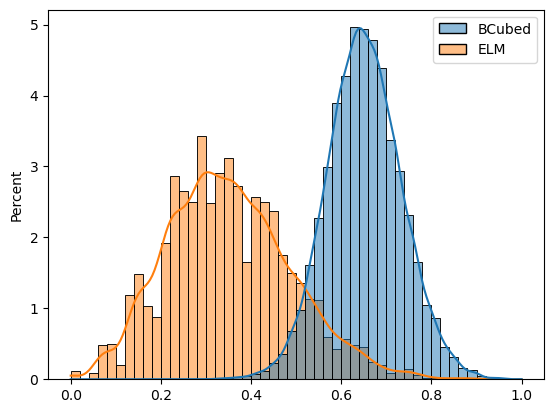

In [7]:
D15.columns=['BCubed','ELM']
sns.histplot(D15, kde=True, stat='percent', binwidth=.02);
plt.savefig("../images/Fig2A.png")
desc_df15 = D15.describe().round(2) 
desc_df15["BCubed-ELM"] = (D15['BCubed'] - D15['ELM']).describe().round(2)
print(desc_df15)

We also make a separate plot with just the distribution of the differences between the two metrics.

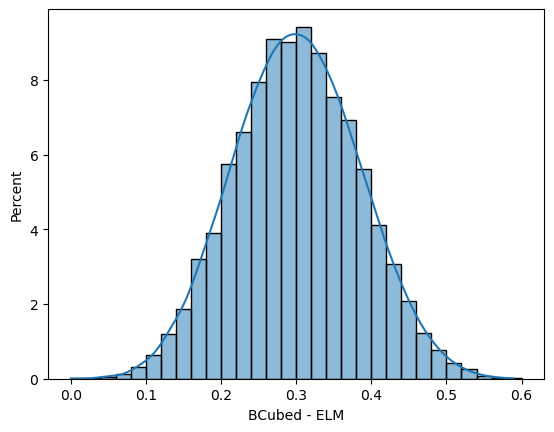

In [8]:
DDiff15= D15.BCubed- D15.ELM
DDiff15.name='BCubed - ELM'
sns.histplot(DDiff15, kde=True, stat='percent', binwidth=.02);
plt.savefig("../images/Fig2B.png") 

<a id="ref2" />

# Experiment with 10 models of length 14 pages (Section 2.4) 

In this experiment we extend the experiment conducted above, where we define 10 different possible gold standard partitions, get the score distritubions over all partitions for each of time, and then aggregate the results. This experiment takes about 2-3 minutes to run.

In [9]:
%%time
gold_standard_models=[[7,7],
                      [5,4,5],
                       [5, 4,2, 3],
                      [4,3,3,4],
                      [5, 2,2,2, 3],
                      [4,1, 4,2, 3],
                      [4,2,3,1,2,2],
                      [3,2,1,1,2,3,2],
                      [2, 3, 2,1,1, 3, 2],
                      [2,1,2,2,1,1,2,1,2]
                     ]

D_14_elements_10_gold_standard = experiment(gold_standard_models ,14)[['bc_F1','elm_F1']]

CPU times: user 2min 19s, sys: 1.23 s, total: 2min 20s
Wall time: 2min 21s


As before, we plot the distributions of the two metrics, and we also plot the distribution of the differences in a seperate plot.

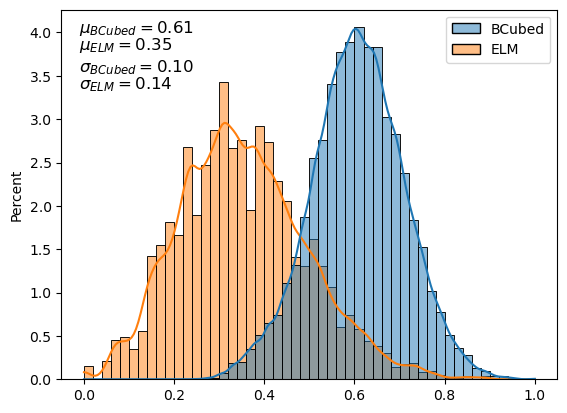

In [10]:
D_14_elements_10_gold_standard.columns= ['BCubed','ELM']

sns.histplot(D_14_elements_10_gold_standard , kde=True, stat='percent', binwidth=.02);

# Put up labels with the mean and standard deviation
plt.text(-0.01, 4, s="$\mu_{BCubed}=%.2f$" % D_14_elements_10_gold_standard['BCubed'].mean(), fontsize=12)
plt.text(-0.01, 3.8, s="$\mu_{ELM}=%.2f$" % D_14_elements_10_gold_standard['ELM'].mean(), fontsize=12)
plt.text(-0.01, 3.55, s="$\sigma_{BCubed}=%.2f$" % D_14_elements_10_gold_standard['BCubed'].std(), fontsize=12)
plt.text(-0.01, 3.35, s="$\sigma_{ELM}=%.2f$" %D_14_elements_10_gold_standard['ELM'].std(), fontsize=12)

plt.savefig("../images/Fig3A.png") 
#D.describe().round(2)


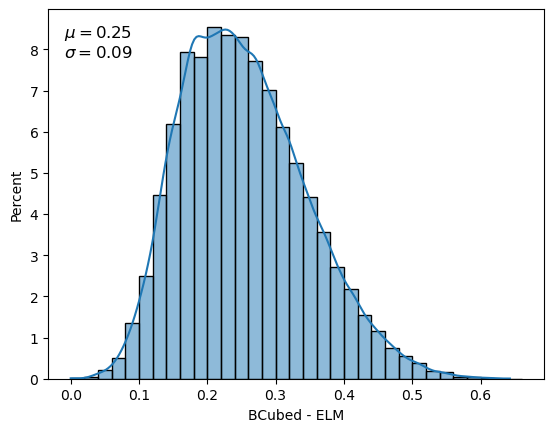

In [11]:
DDiff= D_14_elements_10_gold_standard.BCubed- D_14_elements_10_gold_standard.ELM
DDiff.name='BCubed - ELM'
#sns.displot(DDiff15, kde=True)
sns.histplot(DDiff, kde=True, stat='percent', binwidth=.02);

plt.text(-0.01, 8.3, s="$\mu=%.2f$" % DDiff.mean(), fontsize=12)
plt.text(-0.01, 7.8, s="$\sigma=%.2f$" % DDiff.std(), fontsize=12)

plt.savefig("../images/Fig3B.png") 